# IMAGINE tutorial 1 -- basic elements of the IMAGINE pipeline

### (Using a toy model for the field and a corresponding toy simulator.)

In this tutorial, we focus on introducing the basic building blocks in IMAGINE package and how to use them for assembling a Bayesian analysis pipeline.

We use mock data with only two independent free parameters. First we need to generate the mock data. Then we will assemble all elements needed for the IMAGINE pipeline, execute the pipeline and investigate its results.

The mock data are designed to naively mimic Faraday depth, which is affected linearly by (Galactic) magnetic field and thermal electron density. As a function of position $x$, we define a constant coherent magnetic field component $a0$ and a random magnetic field component which is drawn from a Gaussian distribution with standdard deviation $b0$. The electron density is given by a $cos(x)$ with arbitrary scaling. The mock data values we get are the Faraday depth of a background source at some arbitrary distance: 

$ signal(x) = cos(x) * \mathcal{G}(mean=a0,std=b0;seed=s) $, $x \in (0,2\pi)$

where $\{a0,b0\}$ is the 'physical' parameter set, and $s$ represents the seed for random variable generation.

The purpose is not to fit the exact signal, since it includes a stochastic component, but to fit the amplitude of the signal and of the variations around it.  So this is fitting the strength of the coherent field $a0$ and the amplitude of the random field $b0$.

In [1]:
import numpy as np
import logging as log

## Classes that store Observables (simulated or measured) and covariance matrices
from imagine import Simulations, Measurements, Covariances
## The likelihood class (obviously the Likelihood element)
from imagine import EnsembleLikelihood
## A flat prior
from imagine import FlatPrior
## The pyMultiNest sampler (one possibility for the Sampler element)
from imagine import MultinestPipeline

## The toy model field factory (one possibilty for the Galaxy-Generator element)
from imagine.fields.test_field.test_field_factory import TestFieldFactory
## The toy model simulator (one possibility for the Observable-Generator element)
from imagine.simulators.test.li_simulator import LiSimulator

## visualize posterior with 3rd party corner package (pip install corner)
import corner
import matplotlib
%matplotlib inline
## Mapping internal parameter units to physical units
from imagine.tools.carrier_mapper import unity_mapper

## step 1, prepare mock data

In calculating the mock data values, we introduce noise as:

$ data(x) = signal(x) + noise(x) $

For simplicity, we propose a simple gaussian noise with mean zero and a standard deviation $e$:

$ noise(x) = \mathcal{G}(mean=0,std=e) $ .

We will assume that we have 10 pixels in the x-direction, in the range (0, 2 pi).

Note that we store raw data with shape (ensemble size, data size), `numpy.vstack` makes the data compatible with that.

In [2]:
a0 = 3. # true value of a
b0 = 6. # true value of b
e = 0.1 # std of gaussian measurement error
s = 233 # seed fixed for signal field

size = 10 # data size in measurements
x = np.linspace(0,2.*np.pi,size) # where the observer is looking at

np.random.seed(s) # set seed for signal field

signal = np.multiply (np.cos(x), np.random.normal(loc=a0,scale=b0,size=size))

data = np.vstack([signal + np.random.normal(loc=0.,scale=e,size=size)])

#np.eye returns a 2D array with ones on the diagonal and zeros elsewhere
cov = (e**2) * np.eye(size) # pre-defined according to measurement error

These data will have to be converted to a format that the pipeline can input. This can be done using subclass `Measurements` under baseclass `ObservableDict`, as long as the data are originally in numpy ndarray type.

The `Measurements` object uses a number of fields that we will make use of later, given as a tuple in the first argument:  for example, `('fd','nan','64','nan')` defines a Faraday depth dataset of size 64, while `('sync','23','64','I')` defines a synchrotron total intensity dataset at frequency 23 GHz and of size 64.  For our test case, the frequency and Stokes labels are not necessary, so we set them as 'nan'.  

The second parameter given to `Measurements.append()` is the array of values, and the last is an optional value to indicate that instead of HEALPix maps (the default), these datasets are just simple arrays.  In the HEALPix case, the size is a HEALPix $N_{side}$, while in this test case, it is simply the length of the array.

In [3]:
mock_data = Measurements() # create empty Measrurements object
mock_data.append(('test', 'nan', str(size), 'nan'), data, True)

mock_cov = Covariances() # create empty Covariance object
mock_cov.append(('test', 'nan', str(size), 'nan'), cov, True)

Plot the simulated data as well as the $cos(x)$ function that is the underlying variation.  

The method `Measurements.data` extracts arrays from the `Observable` object which is hosted inside the `ObservableDict` class.

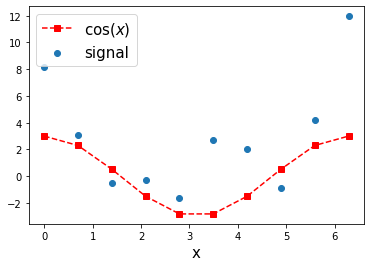

In [4]:
fig,ax = matplotlib.pyplot.subplots()
ax.scatter(x, mock_data[('test', 'nan', str(size), 'nan')].global_data[0], marker='o', label='signal')
ax.plot(x,np.cos(x)*a0,'r--',marker='s',label='$\cos(x)$')
ax.set_xlabel('x',fontsize=15); ax.legend(fontsize=15);

Note that the variance in the signal is highest where the $cos(x)$ is also strongest. This is the way we expect the Faraday depth to work, since a fluctuation in the strength of B has a larger effect on the RM when the nene also happens to be higher.

## step 2, assemble pipeline

Now that we have generated mock data, there are several steps to set up the pipeline to estimate the input parameters.  We need to define field models, simulators, likelihoods and priors.

1) Field models: there are a number of field models included in IMAGINE. We use here the simplest Test Field, which only has two active parameters a and b.  


In [5]:
factory = TestFieldFactory(active_parameters=('a','b')) # factory with single active parameter
factory.parameter_ranges = {'a':(0,10),'b':(0,10)} # adjust parameter range for Bayesian analysis
factory_list = [factory] # a list of factories is required by pipeline

2) Simulators: For this tutorial, we use a custumized test Simulator called LiSimulator. This simulator consists of exactly the function for signal(x) defined above.

In [6]:
simer = LiSimulator(mock_data) # simulator needs to know what observables it should provide

3) Priors: for now, the FlatPrior is all we need.

In [7]:
prior = FlatPrior()

4) Likelihoods: IMAGINE provides the `Likelihood` class with `EnsembleLikelihood` and `SimpleLikelihood` as two options.  The `SimpleLikelihood` is what you expect, computing a single $\chi^2$ from the difference of the simulated and the measured datasets.  The `EnsembleLikelihood` is how IMAGINE handles a signal which itself includes a stochastic component, e.g., what we call the Galactic variance.  This likelihood module makes use of a finite ensemble of simulated realizations and uses their mean and covariance to compare them to the measured dataset.  

In [8]:
likelihood = EnsembleLikelihood(mock_data, mock_cov) # initialize likelihood with measured info

Now we are ready to construct and run the pipeline itself.

As you will see below, the `Pipeline` class takes as input arguments all elements we defined in the lines above to start calculating.

The current two pipelines here are based on different samplers:

1. `MultinestPipeline` : is quite old but fast, has its core in Fortran.
2. `DynestyPipeline`: is new and purely in Python, extremely well documented, but it's slower

Since we are using the `EnsembleLikelihood`, we also need to define an ensemble size, i.e. the number of simulations with the same input parameters that will be generated at each sample. Different realizations of the random magnetic field will render all simulated data sets different; their variance is an estimate of the Galactic variance.

In [9]:
## Generate 100 realizations at each sample
ensemble_size = 100  
## Define the pipeline using the MultiNest sampler, giving it the required elements
pipe = MultinestPipeline(simer, factory_list, likelihood, prior, ensemble_size)
## Set its random seed with a positive integer, or 0 to start randomly from the system clock.  
pipe.random_type = 'free'
## Set some controller parameters that are specific to pyMultiNest.  
pipe.sampling_controllers = {'n_iter_before_update': 1,
                             'n_live_points': 400,
                             'verbose': False,
                             'resume': False}

## step 3, run pipeline

The IMAGINE pipeline use variables which all range within $[0,1]$ internally. This conversion from physical parameters (with arbitrary extrema) and parameters (in range $[0,1]$) is done automatically in the factories. The function `unity_mapper` reads the information in the samples and then then maps the output parameters back to their physical values.

This actually runs the pipeline and will take a few seconds:

In [10]:
results = pipe()

  analysing data from chains/imagine_.txt


Now we can look at the results, which consiste of a set of sampled points in the likelihood space.  

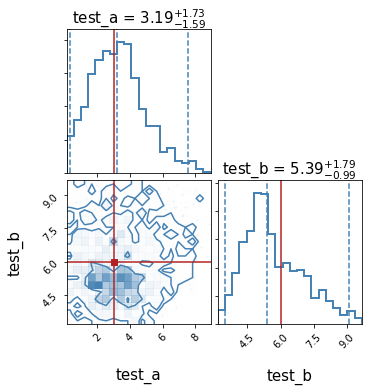

In [11]:
samples = results['samples']  # load sample points

## convert from pipeline-internal (0-1) values into physical parameters
for i in range(len(pipe.active_parameters)): 
    low, high = pipe.active_ranges[pipe.active_parameters[i]]
    for j in range(samples.shape[0]):
        samples[j,i] = unity_mapper(samples[j,i],low,high)

##  See https://corner.readthedocs.io/en/latest/pages/sigmas.html about contour levels.  
##  "Contours are shown at 0.5, 1, 1.5, and 2 sigma" by default
##  according to https://pypi.org/project/corner/1.0.1/, but I want 1, 2, and 3.
sigmas=np.array([1.,2.,3.])
levels=1-np.exp(-0.5*sigmas*sigmas)

# Visualize with a corner plot
figure = corner.corner(samples[:, :len(pipe.active_parameters)],
                      range=[0.99]*len(pipe.active_parameters),
                      quantiles=[0.02, 0.5, 0.98],
                      labels=pipe.active_parameters,
                      show_titles=True,
                      title_kwargs={"fontsize": 15},
                      color='steelblue',
                      truths=[a0,b0],
                      truth_color='firebrick',
                      plot_contours=True,
                      hist_kwargs={'linewidth': 2},
                      label_kwargs={'fontsize': 15},
                      levels=levels)



## step 3a: roll out with a different sampler

Now, use the Dynesty sampler in stead of MultiNest.
The only difference at the frontend is the sampler-dependent controlling parameters. The nice thing about Dynesty is that it provides an informative progress bar under the cell executing it, as you can see.

(This run takes a bit longer, because the sampler needs to be optimized better.)  

iter: 1721 | +400 | bound: 5 | nc: 1 | ncall: 17688 | eff(%): 11.991 | loglstar:   -inf < -24.645 <    inf | logz: -28.059 +/-  0.114 | dlogz:  0.001 >  0.409                                        

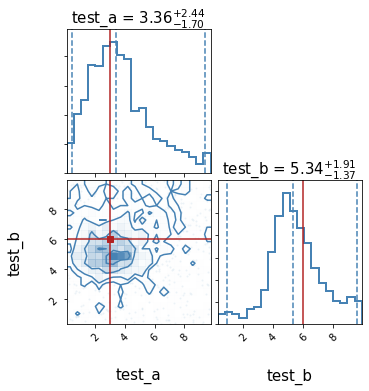

In [12]:
from imagine.pipelines.dynesty_pipeline import DynestyPipeline

pipe = DynestyPipeline(simer, factory_list, likelihood, prior, ensemble_size)
pipe.random_type = 'free'
pipe.sampling_controllers = {'nlive': 400} # mind the difference here

results = pipe()
samples = results['samples']
for i in range(len(pipe.active_parameters)):
    low, high = pipe.active_ranges[pipe.active_parameters[i]]
    for j in range(samples.shape[0]):
        samples[j, i] = unity_mapper(samples[j, i], low, high)
# corner plot
figure = corner.corner(samples[:, :len(pipe.active_parameters)],
                       range=[0.99]*len(pipe.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 15},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 15})

## Addendum: convergence check

The mock data was generated with a fixed random seed, while in the Bayesian analysis time-thread dependent seeds are adopted. Therefore, it is interesting to check if different executions are consistent.  In other words, when you start the sampler at different places, does it always converge on the same region of parameter space?  Let's see what happens when we run it five times and just overplot histograms of the outputs to see if they all look the same.  There are more rigorous tests, of course, that we have done, but they take longer.  This can be done in a few minutes:

iter: 1868 | +400 | bound: 10 | nc: 1 | ncall: 20492 | eff(%): 11.068 | loglstar:   -inf < -24.173 <    inf | logz: -28.015 +/-  0.111 | dlogz:  0.001 >  0.409                                       

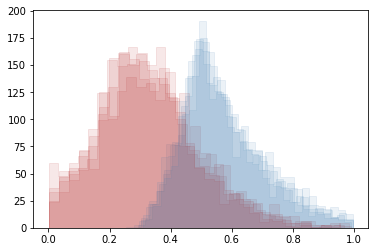

In [13]:
from scipy.stats import norm
repeat = 5

for i in range(repeat):
    tmp = pipe()
    asamp = tmp['samples'][:,0]
    bsamp = tmp['samples'][:,1]
    matplotlib.pyplot.hist(asamp, 30, histtype='step', stacked=True,
                           fill=True, color='firebrick', alpha=0.1)
    matplotlib.pyplot.hist(bsamp, 30, histtype='step', stacked=True,
                           fill=True,label='b',color='steelblue',alpha=0.1)

### This ends tutorial 1. Continue to tutorials 2-5:
The python script for tutorial 1 can be found in [li_multinest](https://bitbucket.org/hammurabicode/imagine/src/master/examples/test_examples/lisimulator_multinest.py) and [li_dynesty](https://bitbucket.org/hammurabicode/imagine/src/master/examples/test_examples/lisimulator_dynesty.py)

* [Tutorial 2](tutorial_two.ipynb):  With a different toy model
* [Tutorial 3](tutorial_three.ipynb):  On calling hammurabiX and/or setting it up for use in an IMAGINE pipeline
* [Tutorial 4](tutorial_four.ipynb):  Data masking
* [Tutorial 5](tutorial_five.ipynb):  An almost realistic pipeline run

Or see more examples in the *imagine/examples* directory